# Survival rate prediction using simple neural network

Step-by-step solution to the data science competition by Women in Data Science Datathon 2020.

1. Data pre-processing: handle missing values, perform categorical encoding.
2. Data exploration: explore relationships, select features.
3. Modelling - design a neural network, try various classifiers, model evaluation, ROC curve.
4. Parameter tuning - select the best model.

### Data pre-processing: handling missing values

In [155]:
import numpy as np
np.random.seed(1337)
import pandas as pd

In [156]:
# loading dataset 
train = pd.read_csv("./widsdatathon2020_data/training_v2.csv")
test = pd.read_csv("./widsdatathon2020_data/unlabeled.csv")

In [157]:
print("Train set shape is", train.shape)
print("Test set shape is %s, %d percent of the training set." %(test.shape, 100*test.shape[0]/train.shape[0]))

Train set shape is (91713, 186)
Test set shape is (39308, 186), 42 percent of the training set.


In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


Fraction of missing values in each column:

Text(0.5, 0, 'Columns')

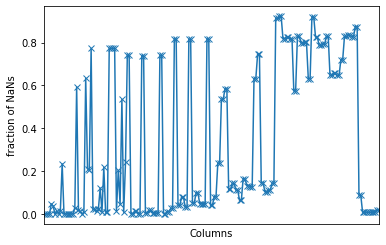

In [159]:
%matplotlib inline
import matplotlib.pyplot as plt
(train.isna().sum()/train.shape[0]).plot(xticks=[], marker='x')
plt.ylabel('fraction of NaNs')
plt.xlabel('Columns')

Drop columns which are missing more than 50% of values.

In [160]:
thresh = len(train) * 0.5
train_df = train.dropna(axis=1, thresh=thresh)
print("New data frame shape is", train_df.shape)

New data frame shape is (91713, 112)


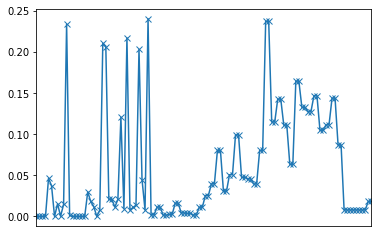

In [161]:
# fractions in remaining columns
(train_df.isna().sum()/train_df.shape[0]).plot(xticks=[], marker='x')

All columns with frac of NaNs> 0.1 will be imputed, for the rest dropped.


In [190]:
# find only numerical columns
filtr = train_df.columns[train_df.isna().sum()>0.1*train_df.shape[0]]
train_df[filtr].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 6 columns):
hospital_admit_source    70304 non-null object
bun_apache               72451 non-null float64
creatinine_apache        72860 non-null float64
d1_bun_min               81199 non-null float64
d1_creatinine_max        81544 non-null float64
d1_creatinine_min        81544 non-null float64
dtypes: float64(5), object(1)
memory usage: 4.2+ MB


In [191]:
# are the numerical columns normally distributed?
filtr = filtr.drop('hospital_admit_source')

In [192]:
filtr

Index(['bun_apache', 'creatinine_apache', 'd1_bun_min', 'd1_creatinine_max',
       'd1_creatinine_min'],
      dtype='object')

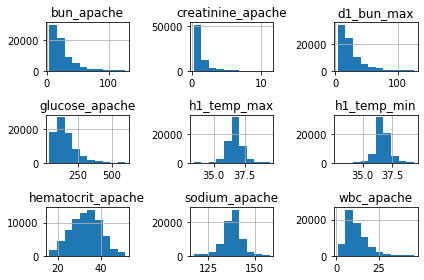

In [178]:
_ = train_df[filtr[0:9].values].hist()
plt.tight_layout()

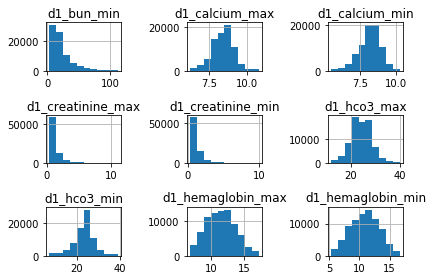

In [179]:
_ = train_df[filtr[9:18].values].hist()
plt.tight_layout()

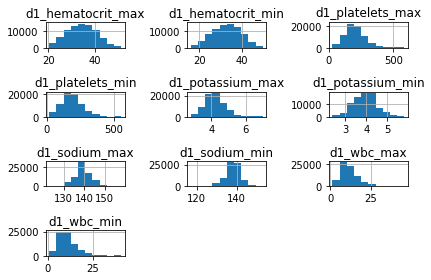

In [180]:
_ = train_df[filtr[18:].values].hist()
plt.tight_layout()

Everything except for *bun_apache, creatinine apache, d1_bun_min, d1_creatinine_max,d1_creayinine_min* has a normal distribution, hence I will be replacing them with means. The rest will be replaced with medians.

In [132]:
from sklearn.impute import SimpleImputer
mean_imp = SimpleImputer(missing_values = np.nan, strategy='mean')
med_imp = SimpleImputer(missing_values = np.nan, strategy='median')

In [193]:
filtr2 = ['bun_apache', 'creatinine_apache', 'd1_bun_min', 'd1_creatinine_max','d1_creatinine_min']

In [194]:
filtr = filtr.drop(filtr2)

In [195]:
filtr

Index([], dtype='object')

In [186]:
train_df[filtr] = mean_imp.fit_transform(train_df[filtr])

/Users/aleksan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/aleksan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [187]:
train_df[filtr].isna().sum()

glucose_apache       0
hematocrit_apache    0
sodium_apache        0
wbc_apache           0
h1_temp_max          0
h1_temp_min          0
d1_bun_max           0
d1_calcium_max       0
d1_calcium_min       0
d1_hco3_max          0
d1_hco3_min          0
d1_hemaglobin_max    0
d1_hemaglobin_min    0
d1_hematocrit_max    0
d1_hematocrit_min    0
d1_platelets_max     0
d1_platelets_min     0
d1_potassium_max     0
d1_potassium_min     0
d1_sodium_max        0
d1_sodium_min        0
d1_wbc_max           0
d1_wbc_min           0
dtype: int64

In [196]:
train_df[filtr2] = med_imp.fit_transform(train_df[filtr2])

/Users/aleksan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/aleksan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [197]:
train_df[filtr2].isna().sum()

bun_apache           0
creatinine_apache    0
d1_bun_min           0
d1_creatinine_max    0
d1_creatinine_min    0
dtype: int64

For the remaining categorical variable:

In [198]:
train_df['hospital_admit_source'].unique()

array(['Floor', 'Emergency Department', 'Operating Room', nan,
       'Direct Admit', 'Other Hospital', 'Other ICU', 'ICU to SDU',
       'Recovery Room', 'Chest Pain Center', 'Step-Down Unit (SDU)',
       'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other'],
      dtype=object)

I will perform backwards filling (could also do a replacement with the most common entry but it may make sense to assume that two consecutive patients were admitted in the same way).

In [199]:
train_df['hospital_admit_source'].fillna(method='bfill', inplace=True)

/Users/aleksan/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In the next step, I will be dropping the rest of the rows with NaNs.

In [200]:
train_df.dropna(inplace=True)

/Users/aleksan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


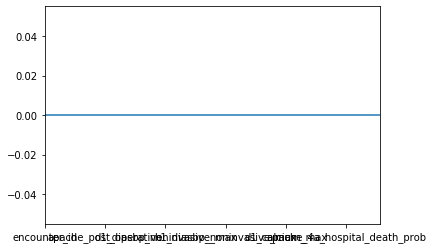

In [201]:
# no NaNs in the dataset
train_df.isna().sum().plot()

In [214]:
print('This missing value handling has retained %d%% rows.' %(train_df.shape[0]/train.shape[0]*100))

This missing value handling has retained 65% rows.


### Data pre-processing: categorical encoding

In [216]:
# 8 categorical columns will be encoded now
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59616 entries, 0 to 91709
Columns: 112 entries, encounter_id to apache_2_bodysystem
dtypes: float64(96), int64(8), object(8)
memory usage: 51.4+ MB


In [219]:
train_df.select_dtypes(include='object').head()

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,Caucasian,M,Floor,Floor,admit,CTICU,Sepsis,Cardiovascular
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,Respiratory,Respiratory
5,Caucasian,M,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,Neurological,Neurologic
10,Hispanic,F,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,Respiratory,Respiratory
17,Hispanic,M,Emergency Department,Accident & Emergency,admit,CTICU,Respiratory,Respiratory


In [246]:
import tabulate
for k in train_df.select_dtypes(include='object').columns:
    print(k, '\n', tabulate.tabulate([train_df[k].unique()]))

ethnicity 
 ---------  --------  ----------------  -----  ---------------  -------------
Caucasian  Hispanic  African American  Asian  Native American  Other/Unknown
---------  --------  ----------------  -----  ---------------  -------------
gender 
 -  -
M  F
-  -
hospital_admit_source 
 -----  ------------  --------------  --------------------  ---------  --------------  ----------  -----------------  -------------  --------------------  ----------------  ----  -----------  ---  -----
Floor  Direct Admit  Operating Room  Emergency Department  Other ICU  Other Hospital  ICU to SDU  Chest Pain Center  Recovery Room  Step-Down Unit (SDU)  Acute Care/Floor  PACU  Observation  ICU  Other
-----  ------------  --------------  --------------------  ---------  --------------  ----------  -----------------  -------------  --------------------  ----------------  ----  -----------  ---  -----
icu_admit_source 
 -----  --------------------  -------------------------  ---------  --------------
Fl

In [247]:
train_df.select_dtypes(include='object').columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

The following encoders will be applied to the groups of :

| type | variable |
|-----|-----|
| one-hot encoding | ethnicity |
|label encoding | gender , icu_admit_source, hospital_admit_source|
|mean encoding |icu_stay_type,  apache_3j_bodysystem,apache_2_bodysystem, icu_type |




In [252]:
# one-hot encoding
onehot = pd.get_dummies(train_df['ethnicity'])
onehot.head(2)

,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown
0,0,0,1,0,0,0
1,0,0,1,0,0,0


In [253]:
train_df[onehot.columns] = onehot
train_df.drop(columns='ethnicity',inplace=True)

/Users/aleksan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [255]:
#label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [259]:
cols = ['gender' , 'icu_admit_source', 'hospital_admit_source']
for col in cols:
    train_df[col] = le.fit_transform(train_df[col])

/Users/aleksan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [262]:
train_df[cols].head(2)

,gender,icu_admit_source,hospital_admit_source
0,1,1,4
1,0,1,4


In [269]:
# mean encoding
cols = ['icu_stay_type', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_type']
for col in cols:
    encode = train_df[[col, 'hospital_death']].groupby(col)['hospital_death'].mean()
    train_df[[col, 'hospital_death']].loc[:,col] = train_df[[col, 'hospital_death']][col].map(encode)

train_df.drop(columns = cols,inplace=True)

/Users/aleksan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [271]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59616 entries, 0 to 91709
Columns: 113 entries, encounter_id to Other/Unknown
dtypes: float64(96), int64(11), uint8(6)
memory usage: 52.0 MB


### Data exploration: feature selection

- handle highly correlated features
- remove features with zero importance in a tree-based model

In [272]:
# find correlated features
corr_df = train_df.corr().abs()
corr_df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,gender,height,hospital_admit_source,...,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown
encounter_id,1.000000,0.002039,0.004403,0.001789,0.004328,0.001200,0.003604,0.003002,0.005407,0.003214,...,0.001741,0.001758,0.000712,0.004496,0.008843,0.001857,0.004842,0.005430,0.000807,0.002897
patient_id,0.002039,1.000000,0.006519,0.004344,0.006070,0.000747,0.006132,0.003646,0.004909,0.001182,...,0.000565,0.001143,0.002319,0.005544,0.005423,0.003093,0.005429,0.001323,0.003097,0.001221
hospital_id,0.004403,0.006519,1.000000,0.000082,0.010628,0.011703,0.038914,0.010663,0.031141,0.029928,...,0.000298,0.004670,0.005151,0.007680,0.019013,0.020285,0.059649,0.053702,0.001721,0.027791
hospital_death,0.001789,0.004344,0.000082,1.000000,0.109047,0.027902,0.082946,0.000140,0.011747,0.020468,...,0.048078,0.033027,0.019725,0.058216,0.015095,0.002471,0.014332,0.001009,0.004441,0.007463
age,0.004328,0.006070,0.010628,0.109047,1.000000,0.080958,0.056040,0.034998,0.117722,0.032587,...,0.023494,0.030159,0.021319,0.025819,0.114517,0.007943,0.131281,0.000861,0.060950,0.055444


In [275]:
#upper triangle
matrix = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
matrix.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,gender,height,hospital_admit_source,...,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown
encounter_id,NaN,0.002039,0.004403,0.001789,0.004328,0.001200,0.003604,0.003002,0.005407,0.003214,...,0.001741,0.001758,0.000712,0.004496,0.008843,0.001857,0.004842,0.005430,0.000807,0.002897
patient_id,NaN,NaN,0.006519,0.004344,0.006070,0.000747,0.006132,0.003646,0.004909,0.001182,...,0.000565,0.001143,0.002319,0.005544,0.005423,0.003093,0.005429,0.001323,0.003097,0.001221
hospital_id,NaN,NaN,NaN,0.000082,0.010628,0.011703,0.038914,0.010663,0.031141,0.029928,...,0.000298,0.004670,0.005151,0.007680,0.019013,0.020285,0.059649,0.053702,0.001721,0.027791
hospital_death,NaN,NaN,NaN,NaN,0.109047,0.027902,0.082946,0.000140,0.011747,0.020468,...,0.048078,0.033027,0.019725,0.058216,0.015095,0.002471,0.014332,0.001009,0.004441,0.007463
age,NaN,NaN,NaN,NaN,NaN,0.080958,0.056040,0.034998,0.117722,0.032587,...,0.023494,0.030159,0.021319,0.025819,0.114517,0.007943,0.131281,0.000861,0.060950,0.055444


In [276]:
# drop columns which display collinearity
to_drop = [col for col in matrix.columns if any(matrix[col] > 0.9)]

In [278]:
to_drop

['apache_post_operative',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_sysbp_noninvasive_max',
 'h1_sysbp_noninvasive_min',
 'd1_bun_max',
 'd1_bun_min',
 'd1_creatinine_max',
 'd1_creatinine_min',
 'd1_glucose_max',
 'd1_hematocrit_max',
 'd1_hematocrit_min',
 'd1_platelets_min',
 'd1_wbc_max',
 'd1_wbc_min']

In [279]:
# drop the columns
train_df.drop(columns = to_drop, inplace=True)

In [280]:
train_df.shape

(59616, 90)

In [284]:
# find features with zero importance in a tree-based model
import lightgbm as lgb

/Users/aleksan/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [302]:
# Gradient Boosting Decision Tree Algorithm
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 20000, class_weight = 'balanced')

In [295]:
feature_importances = np.zeros(train_df.shape[1])
y = train_df['hospital_death']
X = train_df
X = train_df.drop('hospital_death',axis = 1)
test = test.drop('hospital_death',axis = 1)

KeyError: "['hospital_death'] not found in axis"

In [305]:
from sklearn.model_selection import train_test_split
# Split into training and validation set
tr_x, te_x, tr_y, te_y = train_test_split(X, y, test_size = 0.3, random_state = 100)

# Train using early stopping
model.fit(tr_x, tr_y, early_stopping_rounds=100, eval_set = [(te_x, te_y)],eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's auc: 0.887699	valid_0's binary_logloss: 0.342191


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [307]:
feature_importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

,feature,importance
73,apache_4a_hospital_death_prob,130
4,bmi,78
74,apache_4a_icu_death_prob,77
68,d1_platelets_max,73
42,d1_spo2_min,71


In [308]:
# features with zero importance
zero = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
feature_importances.tail()

,feature,importance
81,lymphoma,0
76,cirrhosis,0
21,gcs_unable_apache,0
12,readmission_status,0
88,Other/Unknown,0


In [312]:
# Drop features with zero importance
print("Number of columns to drop:", len(zero))
X = X.drop(columns = zero)

Number of columns to drop: 8


In [313]:
X.shape

(59616, 81)

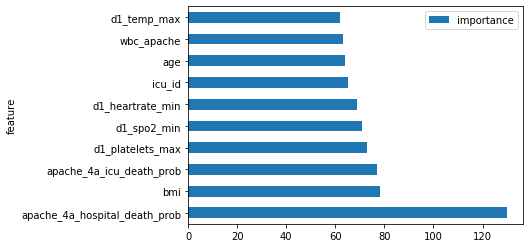

In [340]:
feature_importances.sort_values('importance', ascending=False)[:10].plot.barh(x='feature')

In [341]:
# explanation of the most important features
explain = feature_importances.sort_values('importance', ascending=False)[:10]['feature']

In [348]:
dictionary = pd.read_csv('./widsdatathon2020_data/WiDS Datathon 2020 Dictionary.csv')
dictionary.head(2)

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None


In [355]:
dictionary['Description'][explain.isin(dictionary['Variable Name']).index]

73    The patient's highest diastolic blood pressure...
4              The age of the patient on unit admission
74    The patient's lowest diastolic blood pressure ...
68    The patient's lowest systolic blood pressure d...
42    The sodium concentration measured during the f...
36    The mean arterial pressure measured during the...
10    The location of the patient prior to being adm...
3     Whether the patient died during this hospitali...
32    The glucose concentration measured during the ...
45    Whether the patient was invasively ventilated ...
Name: Description, dtype: object

### Modelling: neural networks

In [356]:
# unique labels in the output
y.unique()

array([0, 1])

In [357]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [358]:
x_train.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,gender,height,hospital_admit_source,icu_admit_source,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,solid_tumor_with_metastasis,African American,Caucasian,Hispanic
64341,100575,75130,19,57.0,28.680041,0,0,163.0,3,0,...,0.09,0.04,0.0,0.0,0.0,0.0,0.0,0,1,0
42761,77997,45211,100,78.0,25.390625,1,1,160.0,8,2,...,0.06,0.03,0.0,0.0,0.0,0.0,0.0,0,1,0
54500,44108,27071,194,75.0,19.283747,0,0,165.0,3,0,...,0.10,0.05,0.0,0.0,0.0,0.0,0.0,0,1,0
33834,70243,30453,109,67.0,26.589749,0,0,162.6,3,0,...,0.03,0.01,0.0,0.0,0.0,0.0,0.0,0,1,0
36688,22661,53532,70,27.0,31.368228,0,1,165.0,4,1,...,0.07,0.02,0.0,0.0,0.0,0.0,0.0,0,1,0


In [359]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD

In [360]:
# standardize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scale = scaler.fit_transform(x_train.values)
x_scale_test = scaler.fit_transform(x_test.values)

In [432]:
#train a model
model = Sequential()
n_cols = x_train.shape[1]
model.add(Dense(10,activation='relu', input_shape=(n_cols,)))
model.add(Dense(1))

sgd = optimizers.SGD(lr=0.001)
optimizer = model.compile(sgd, loss='binary_crossentropy',metrics=['accuracy'])

predictions = model.fit(x_scale,y_train, validation_data=(x_scale_test,y_test), epochs=50, batch_size=100)

Train on 47692 samples, validate on 11924 samples
Epoch 1/50
47692/47692 [==============================] - 3s 54us/sample - loss: 0.7115 - acc: 0.9009 - val_loss: 0.3710 - val_acc: 0.9147
Epoch 2/50
47692/47692 [==============================] - 1s 30us/sample - loss: 0.3697 - acc: 0.9130 - val_loss: 0.3222 - val_acc: 0.9170
Epoch 3/50
47692/47692 [==============================] - 2s 34us/sample - loss: 0.3137 - acc: 0.9145 - val_loss: 0.2698 - val_acc: 0.9182
Epoch 4/50
47692/47692 [==============================] - 2s 32us/sample - loss: 0.2604 - acc: 0.9155 - val_loss: 0.2489 - val_acc: 0.9181
Epoch 5/50
47692/47692 [==============================] - 2s 33us/sample - loss: 0.2494 - acc: 0.9157 - val_loss: 0.2440 - val_acc: 0.9188
Epoch 6/50
47692/47692 [==============================] - 1s 31us/sample - loss: 0.3115 - acc: 0.9094 - val_loss: 0.3501 - val_acc: 0.9201
Epoch 7/50
47692/47692 [==============================] - 2s 37us/sample - loss: 0.2713 - acc: 0.9158 - val_loss: 0.

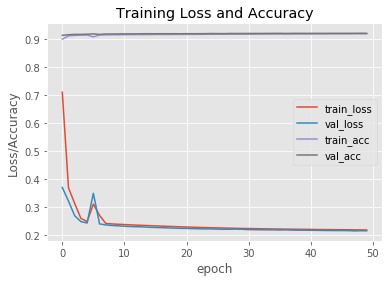

In [433]:
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, predictions.history["loss"], label="train_loss")
plt.plot(N, predictions.history["val_loss"], label="val_loss")
plt.plot(N, predictions.history["acc"], label="train_acc")
plt.plot(N, predictions.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

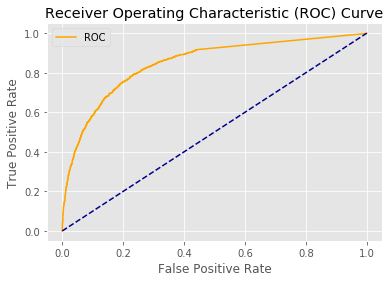

AUC-ROC : 0.8479173314239494


In [434]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
probs = model.predict_proba(x_scale_test)
probs = probs[:]
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)

In [375]:
# more sophisticated model

In [378]:
model2 = Sequential()
model2.add(Dense(128, input_shape=(81,), activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(2, activation='softmax'))
optim = optimizers.SGD(lr=0.01)
model2.compile(optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [379]:
predictions2 = model2.fit(x_scale,y_train, validation_data=(x_scale_test,y_test), epochs=100)

Train on 47692 samples, validate on 11924 samples
Epoch 1/100
47692/47692 [==============================] - 4s 88us/sample - loss: 0.2470 - acc: 0.9148 - val_loss: 0.2218 - val_acc: 0.9210
Epoch 2/100
47692/47692 [==============================] - 4s 80us/sample - loss: 0.2195 - acc: 0.9211 - val_loss: 0.2139 - val_acc: 0.9228
Epoch 3/100
47692/47692 [==============================] - 4s 85us/sample - loss: 0.2146 - acc: 0.9221 - val_loss: 0.2088 - val_acc: 0.9241
Epoch 4/100
47692/47692 [==============================] - 4s 82us/sample - loss: 0.2120 - acc: 0.9232 - val_loss: 0.2100 - val_acc: 0.9232
Epoch 5/100
47692/47692 [==============================] - 4s 81us/sample - loss: 0.2098 - acc: 0.9241 - val_loss: 0.2045 - val_acc: 0.9242
Epoch 6/100
47692/47692 [==============================] - 4s 88us/sample - loss: 0.2090 - acc: 0.9238 - val_loss: 0.2109 - val_acc: 0.9217
Epoch 7/100
47692/47692 [==============================] - 4s 80us/sample - loss: 0.2082 - acc: 0.9242 - val_l

Epoch 59/100
47692/47692 [==============================] - 4s 80us/sample - loss: 0.1900 - acc: 0.9299 - val_loss: 0.1935 - val_acc: 0.9278
Epoch 60/100
47692/47692 [==============================] - 4s 81us/sample - loss: 0.1896 - acc: 0.9306 - val_loss: 0.1992 - val_acc: 0.9258
Epoch 61/100
47692/47692 [==============================] - 4s 81us/sample - loss: 0.1891 - acc: 0.9303 - val_loss: 0.1980 - val_acc: 0.9285
Epoch 62/100
47692/47692 [==============================] - 4s 80us/sample - loss: 0.1887 - acc: 0.9305 - val_loss: 0.1939 - val_acc: 0.9283
Epoch 63/100
47692/47692 [==============================] - 4s 81us/sample - loss: 0.1887 - acc: 0.9301 - val_loss: 0.1941 - val_acc: 0.9273
Epoch 64/100
47692/47692 [==============================] - 4s 82us/sample - loss: 0.1884 - acc: 0.9311 - val_loss: 0.1969 - val_acc: 0.9266
Epoch 65/100
47692/47692 [==============================] - 4s 81us/sample - loss: 0.1877 - acc: 0.9306 - val_loss: 0.1960 - val_acc: 0.9272
Epoch 66/100


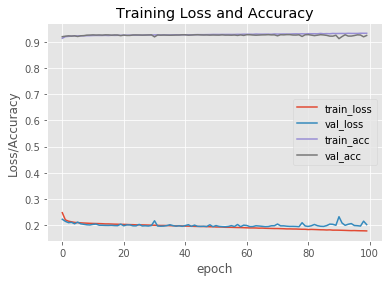

In [396]:
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, predictions2.history["loss"], label="train_loss")
plt.plot(N, predictions2.history["val_loss"], label="val_loss")
plt.plot(N, predictions2.history["acc"], label="train_acc")
plt.plot(N, predictions2.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [397]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               10496     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 18,882
Trainable params: 18,882
Non-trainable params: 0
_________________________________________________________________


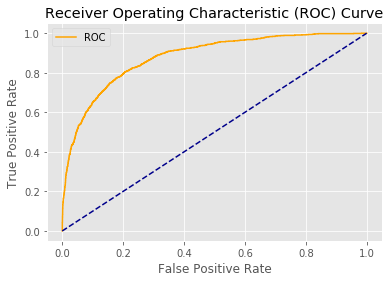

AUC-ROC : 0.8796451685532067


In [398]:
probs = model2.predict_proba(x_scale_test)
probs = probs[:,1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)

### Modelling: k nearest neighbours

In [421]:
# define the baseline model for classification
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(x_scale,y_train)
baseline_acc = dummy.score(x_scale_test, y_test)

In [412]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(x_scale, y_train)
knn_acc = knn.score(x_scale_test, y_test)

### Modelling: model evaluation

Text(0.5, 1.0, 'Delta of accuracy between a model and a baseline')

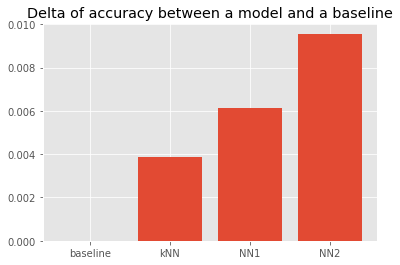

In [436]:
# model evaluation
models = ['baseline', 'kNN', 'NN1', 'NN2']
acc = [baseline_acc-baseline_acc, knn_acc-baseline_acc, predictions.history["val_acc"][-1]-baseline_acc,predictions2.history["val_acc"][-1]-baseline_acc]
plt.bar(models, acc)
plt.title('Delta of accuracy between a model and a baseline')

### Modelling: hyperparameter tuning